## Modeling Survival on the Titanic

In [1]:
import pandas as pd
import numpy as np
import re
import pickle

In [2]:
import plotly as py
import plotly.graph_objs as go

In [3]:
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [4]:
# Define the color palette 
Viridis=[
"#440154", "#440558", "#450a5c", "#450e60", "#451465", "#461969",
"#461d6d", "#462372", "#472775", "#472c7a", "#46307c", "#45337d",
"#433880", "#423c81", "#404184", "#3f4686", "#3d4a88", "#3c4f8a",
"#3b518b", "#39558b", "#37598c", "#365c8c", "#34608c", "#33638d",
"#31678d", "#2f6b8d", "#2d6e8e", "#2c718e", "#2b748e", "#29788e",
"#287c8e", "#277f8e", "#25848d", "#24878d", "#238b8d", "#218f8d",
"#21918d", "#22958b", "#23988a", "#239b89", "#249f87", "#25a186",
"#25a584", "#26a883", "#27ab82", "#29ae80", "#2eb17d", "#35b479",
"#3cb875", "#42bb72", "#49be6e", "#4ec16b", "#55c467", "#5cc863",
"#61c960", "#6bcc5a", "#72ce55", "#7cd04f", "#85d349", "#8dd544",
"#97d73e", "#9ed93a", "#a8db34", "#b0dd31", "#b8de30", "#c3df2e",
"#cbe02d", "#d6e22b", "#e1e329", "#eae428", "#f5e626", "#fde725"]
# source: https://bhaskarvk.github.io/colormap/reference/colormap.html

### Read in the titanic dataset

In [5]:
df = pd.read_csv('resources/titanic.csv')
# df = pd.read_csv("https://raw.githubusercontent.com/austinlasseter/plotly_dash_tutorial/master/00%20resources/titanic.csv")
print(df.shape)
df.head()

(712, 8)


,Survived,Pclass,Sex,Age,Fare,Embarked,Name,SibSp
0,0,3,male,22.0,7.2500,Southampton,"Braund, Mr. Owen Harris",1
1,1,1,female,38.0,71.2833,Cherbourg,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1
2,1,3,female,26.0,7.9250,Southampton,"Heikkinen, Miss. Laina",0
3,1,1,female,35.0,53.1000,Southampton,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1
4,0,3,male,35.0,8.0500,Southampton,"Allen, Mr. William Henry",0


### Train Test Split

In [6]:
#NEW Train test split
#X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

# Split train into train & val.  You should split as early as possible.
train, val = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df['Survived'], random_state=42)



In [7]:
print(train.shape)
print(val.shape)

(569, 8)
(143, 8)


In [8]:
import numpy as np

In [9]:
# instantiation
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                        unknown_value=np.nan)

### Features

In [21]:
# Make some dummies for sex.
#df = pd.get_dummies(df, prefix='', prefix_sep='', columns=['Sex'])

In [22]:
# Make some dummies Passenger's cabin class
#df = pd.get_dummies(df, prefix='Cabin Class', prefix_sep=' ', columns=['Pclass'])

In [23]:
# Make some dummies Passenger's embarkation
#df = pd.get_dummies(df, prefix='', prefix_sep='', columns=['Embarked'])

In [10]:
# Siblings and Spouses - with train/test split you don't need this anymore
df=df.rename(columns={'SibSp':'Siblings and Spouses'})
df['Siblings and Spouses'].value_counts()

0    469
1    183
2     25
4     18
3     12
5      5
Name: Siblings and Spouses, dtype: int64

In [11]:
# Siblings and Spouses - Train
# Siblings and Spouses
train=train.rename(columns={'SibSp':'Siblings and Spouses'})
train['Siblings and Spouses'].value_counts()

0    378
1    142
2     17
4     17
3     11
5      4
Name: Siblings and Spouses, dtype: int64

In [12]:
# Siblings and Spouses - Val
# Siblings and Spouses
val=val.rename(columns={'SibSp':'Siblings and Spouses'})
val['Siblings and Spouses'].value_counts()

0    91
1    41
2     8
3     1
5     1
4     1
Name: Siblings and Spouses, dtype: int64

In [13]:
df.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Name,Siblings and Spouses
0,0,3,male,22.0,7.2500,Southampton,"Braund, Mr. Owen Harris",1
1,1,1,female,38.0,71.2833,Cherbourg,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1


In [14]:
train.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Name,Siblings and Spouses
472,1,1,male,49.0,56.9292,Cherbourg,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",1
28,0,3,male,21.0,8.0500,Southampton,"Cann, Mr. Ernest Charles",0


In [15]:
val.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Name,Siblings and Spouses
150,1,2,female,32.0,13.000,Southampton,"Pinsky, Mrs. (Rosa)",0
235,0,2,male,36.0,12.875,Cherbourg,"Levy, Mr. Rene Jacques",0


In [30]:
# age requires binning
#print(df.Age.describe())
#print(df.Age.describe()['25%'])

In [31]:
# Age
#bins=[1, 20, 28, 38, 80]
#df['age_binned']=pd.cut(df['Age'], bins)
#df['age_binned'].value_counts().sort_index()

In [16]:
#df = pd.get_dummies(df, prefix='Age', prefix_sep=' ', columns=['age_binned'])
df.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Name,Siblings and Spouses
0,0,3,male,22.0,7.2500,Southampton,"Braund, Mr. Owen Harris",1
1,1,1,female,38.0,71.2833,Cherbourg,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1


In [17]:
# Name
df['Last Name']=df['Name'].apply(lambda x: x.split(',')[0])
df['First Name']=df['Name'].apply(lambda x: x.split(',')[1])
df['Title']=df['First Name'].apply(lambda x: x.split('.')[0])

In [18]:
# Name - Train
train['Last Name']=train['Name'].apply(lambda x: x.split(',')[0])
train['First Name']=train['Name'].apply(lambda x: x.split(',')[1])
train['Title']=train['First Name'].apply(lambda x: x.split('.')[0])

In [19]:
# Name - Val
val['Last Name']=val['Name'].apply(lambda x: x.split(',')[0])
val['First Name']=val['Name'].apply(lambda x: x.split(',')[1])
val['Title']=val['First Name'].apply(lambda x: x.split('.')[0])

In [20]:
df.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Name,Siblings and Spouses,Last Name,First Name,Title
0,0,3,male,22.0,7.2500,Southampton,"Braund, Mr. Owen Harris",1,Braund,Mr. Owen Harris,Mr
1,1,1,female,38.0,71.2833,Cherbourg,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,Cumings,Mrs. John Bradley (Florence Briggs Thayer),Mrs


In [21]:
train.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Name,Siblings and Spouses,Last Name,First Name,Title
472,1,1,male,49.0,56.9292,Cherbourg,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",1,Duff Gordon,"Sir. Cosmo Edmund (""Mr Morgan"")",Sir
28,0,3,male,21.0,8.0500,Southampton,"Cann, Mr. Ernest Charles",0,Cann,Mr. Ernest Charles,Mr


In [22]:
val.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Name,Siblings and Spouses,Last Name,First Name,Title
150,1,2,female,32.0,13.000,Southampton,"Pinsky, Mrs. (Rosa)",0,Pinsky,Mrs. (Rosa),Mrs
235,0,2,male,36.0,12.875,Cherbourg,"Levy, Mr. Rene Jacques",0,Levy,Mr. Rene Jacques,Mr


In [23]:
#drop Name, Last Name, First Name
df.drop(['Name', 'Last Name', 'First Name'], axis=1, inplace= True)

In [24]:
#drop Name, Last Name, First Name - Train
train.drop(['Name', 'Last Name', 'First Name'], axis=1, inplace= True)

In [25]:
#drop Name, Last Name, First Name - Val
val.drop(['Name', 'Last Name', 'First Name'], axis=1, inplace= True)

In [26]:
df.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Siblings and Spouses,Title
0,0,3,male,22.0,7.2500,Southampton,1,Mr
1,1,1,female,38.0,71.2833,Cherbourg,1,Mrs


In [27]:
train.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Siblings and Spouses,Title
472,1,1,male,49.0,56.9292,Cherbourg,1,Sir
28,0,3,male,21.0,8.0500,Southampton,0,Mr


In [28]:
val.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Siblings and Spouses,Title
150,1,2,female,32.0,13.000,Southampton,0,Mrs
235,0,2,male,36.0,12.875,Cherbourg,0,Mr


In [29]:
# The status_group column is the target
target = 'Survived'
y_train = train[target]
y_val = val[target]

In [30]:
#Identity non-numerical columns
train.select_dtypes(exclude='number').columns

Index(['Sex', 'Embarked', 'Title'], dtype='object')

In [31]:
categorical_features = train.select_dtypes(exclude='number').columns.tolist()
categorical_features

['Sex', 'Embarked', 'Title']

In [32]:
train[categorical_features]

,Sex,Embarked,Title
472,male,Cherbourg,Sir
28,male,Southampton,Mr
440,male,Southampton,Mr
646,male,Southampton,Mr
287,male,Southampton,Mr
...,...,...,...
154,female,Cherbourg,Mrs
475,male,Cherbourg,Mr
678,female,Cherbourg,Miss
584,male,Southampton,Mr


In [33]:
train.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Siblings and Spouses,Title
472,1,1,male,49.0,56.9292,Cherbourg,1,Sir
28,0,3,male,21.0,8.0500,Southampton,0,Mr


In [34]:
#Drop target from train
X_train = train.drop('Survived', axis=1, inplace=True)

In [35]:
X_train = train

In [36]:
X_train.head(2)

,Pclass,Sex,Age,Fare,Embarked,Siblings and Spouses,Title
472,1,male,49.0,56.9292,Cherbourg,1,Sir
28,3,male,21.0,8.0500,Southampton,0,Mr


In [37]:
#Drop target from val
X_val = val.drop('Survived', axis=1, inplace=True)

In [38]:
X_val = val

In [39]:
X_val.head(2)

,Pclass,Sex,Age,Fare,Embarked,Siblings and Spouses,Title
150,2,female,32.0,13.000,Southampton,0,Mrs
235,2,male,36.0,12.875,Cherbourg,0,Mr


In [40]:
##Ordinal Encoder

In [41]:
import numpy as np

In [42]:
# instantiation
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                        unknown_value=np.nan)

In [43]:
# remember the distinction we made between categorical and continuous (i.e., numeric) features
#categorical features need to be encoded with OrdinalEncoder.  Scikit learn can't handle string values
print(X_train[categorical_features].columns)
#don't need to be encoded with OrdinalEncoder becuase they are already numeric
#print(X_train[numeric_features].columns)

Index(['Sex', 'Embarked', 'Title'], dtype='object')


In [44]:
#Use OrdinalEncoder on categorical features
X_train[categorical_features] = encoder.fit_transform(X_train[categorical_features])

In [45]:
X_train.head(1).T

,472
Pclass,1.0000
Sex,1.0000
Age,49.0000
Fare,56.9292
Embarked,0.0000
Siblings and Spouses,1.0000
Title,14.0000


In [46]:
#Check for missing data
X_train.isnull().sum()

Pclass                  0
Sex                     0
Age                     0
Fare                    0
Embarked                0
Siblings and Spouses    0
Title                   0
dtype: int64

In [47]:
#Use OrdinalEncoder on categorical features - val (only transform)
X_val[categorical_features] = encoder.transform(X_val[categorical_features])

In [48]:
X_val.head(1).T

,150
Pclass,2.0
Sex,0.0
Age,32.0
Fare,13.0
Embarked,2.0
Siblings and Spouses,0.0
Title,11.0


In [49]:
#Check for missing data
X_val.isnull().sum()

Pclass                  0
Sex                     0
Age                     0
Fare                    0
Embarked                0
Siblings and Spouses    0
Title                   2
dtype: int64

In [50]:
###Impute missing data

In [51]:
# instantiation
from sklearn.impute import SimpleImputer

In [52]:
# because we used label encoder, it doesn't make sense to use "mean" as a strategy
# for categorical variables which are encoded, missing data should be replaced by the median or 'most_frequent', not mean!
imputer = SimpleImputer(strategy='most_frequent')

In [53]:
# data imputation will account for any missing data (fit on the training data).  No missing train data -- does it matter that we still did this step??
X_train_imputed = imputer.fit_transform(X_train)

In [54]:
# confirm that all missing data has been accounted for.
print('before imputation: ', pd.DataFrame(X_train).isnull().sum().sum())
print('after imputation: ', pd.DataFrame(X_train_imputed).isnull().sum().sum())

before imputation:  0
after imputation:  0


In [55]:
# data imputation will account for any missing data (fit on the training data) - val
X_val_imputed = imputer.transform(X_val)

In [56]:
# confirm that all missing data has been accounted for. - val
print('before imputation: ', pd.DataFrame(X_val).isnull().sum().sum())
print('after imputation: ', pd.DataFrame(X_val_imputed).isnull().sum().sum())

before imputation:  2
after imputation:  0


In [57]:
#Standardization
# import & instantiate
from sklearn.preprocessing import StandardScaler, Normalizer
scaler = StandardScaler()

In [58]:
# Standardization will ensure all features are on the same scale (fit on the training data)
X_train_scaled = scaler.fit_transform(X_train_imputed)

In [59]:
# confirm that did what we wanted (mean of zero, std of 1)
print(round(X_train_scaled.mean(), 1))
print(round(X_train_scaled.std(), 1))

0.0
1.0


In [60]:
# Standardization will ensure all features are on the same scale (fit on the training data) - val
X_val_scaled = scaler.transform(X_val_imputed)

In [61]:
# confirm that did what we wanted (mean of zero, std of 1) - val
print(round(X_val_scaled.mean(), 1))
print(round(X_val_scaled.std(), 1))

0.0
1.1


In [62]:
#Decision Tree
#instantiate

from sklearn.tree import DecisionTreeClassifier

In [63]:
# Just a note: remember that we have imbalanced classes in our target variable!
y_train.value_counts(normalize=True)

0    0.595782
1    0.404218
Name: Survived, dtype: float64

In [64]:
# how do we find the optimal hyperparameters? these are just a guess. more on this later!
model = DecisionTreeClassifier(max_depth=7, 
                               criterion='entropy', 
                               min_samples_leaf=10,
                               class_weight='balanced')

In [65]:
# Fit the decision tree model to the training data
model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, min_samples_leaf=10)

In [66]:
# we can evaluate using our validation data
y_pred_val = model.predict(X_val_scaled)
y_pred_val[:10]

array([1, 0, 0, 1, 0, 0, 0, 1, 0, 1])

In [67]:
# evaluate the confusion matrix
from sklearn import metrics
metrics.confusion_matrix(y_val, y_pred_val)

array([[65, 20],
       [13, 45]])

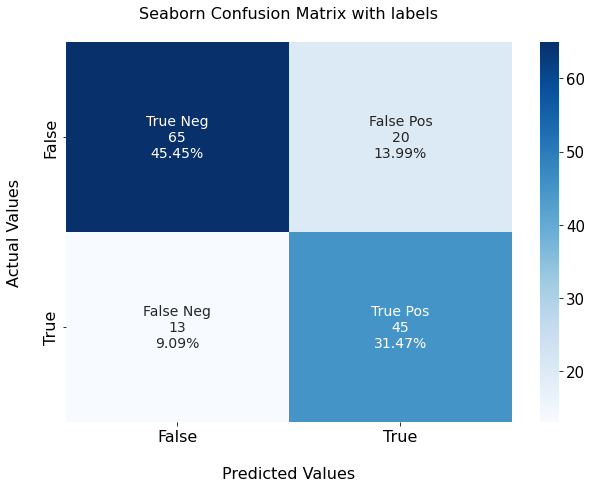

In [68]:
#visualize confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cf_matrix = metrics.confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(10,7))

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size":14})

ax.set_title('Seaborn Confusion Matrix with labels\n', fontsize = 16);
ax.set_xlabel('\nPredicted Values',fontsize = 16)
ax.set_ylabel('Actual Values\n',fontsize = 16);

# Set font size for colorbar labels
ax.figure.axes[-1].tick_params(labelsize=15)


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'],fontsize = 16)
ax.yaxis.set_ticklabels(['False','True'], fontsize = 16) 

## Display the visualization of the Confusion Matrix.
plt.show()

In [69]:
# evaluate the classification report
print(metrics.classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.83      0.76      0.80        85
           1       0.69      0.78      0.73        58

    accuracy                           0.77       143
   macro avg       0.76      0.77      0.76       143
weighted avg       0.78      0.77      0.77       143



In [70]:
### Gridsearch with decision tree

In [71]:
# instantiate your model
model = DecisionTreeClassifier()

In [72]:
# define your parameter grid 
param_grid = {
                'max_depth':[5,10,15,20, 25], 
                'criterion':['entropy','gini'], 
                'min_samples_leaf':[6,10,20,22,25],
                'class_weight':['balanced', None]
             }

In [73]:
# establish cross-validation and gridsearch
grid_search = GridSearchCV(model, param_grid, cv=10, verbose=1,n_jobs=-1)

In [74]:
# conduct the search
grid_search.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [5, 10, 15, 20, 25],
                         'min_samples_leaf': [6, 10, 20, 22, 25]},
             verbose=1)

In [75]:
# see the best parameters and their score
print("Best parameters:")
print(grid_search.best_params_)
print("Best score in grid search:")
print(grid_search.best_score_)
print("best model from grid search:")
# Questions - Why do you score using validation data and not training data
print(grid_search.score(X_val_scaled, y_val))

Best parameters:
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 6}
Best score in grid search:
0.8153508771929825
best model from grid search:
0.7762237762237763


In [76]:
# we can evaluate using our validation data
y_pred_val = grid_search.predict(X_val_scaled)
y_pred_val[:10]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [77]:
# evaluate the confusion matrix
from sklearn import metrics
metrics.confusion_matrix(y_val, y_pred_val)

array([[71, 14],
       [18, 40]])

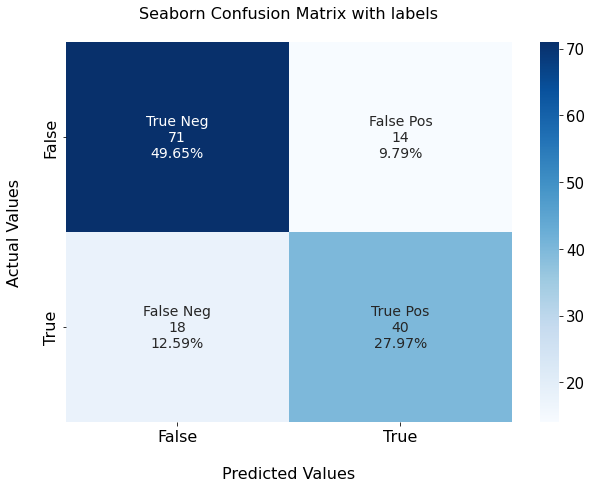

In [79]:
#Visualize confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cf_matrix = metrics.confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(10,7))

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size":14})

ax.set_title('Seaborn Confusion Matrix with labels\n', fontsize = 16);
ax.set_xlabel('\nPredicted Values',fontsize = 16)
ax.set_ylabel('Actual Values\n',fontsize = 16);

# Set font size for colorbar labels
ax.figure.axes[-1].tick_params(labelsize=15)


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'],fontsize = 16)
ax.yaxis.set_ticklabels(['False','True'], fontsize = 16) 

## Display the visualization of the Confusion Matrix.
plt.show()

In [80]:
# evaluate the classification report
print(metrics.classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        85
           1       0.74      0.69      0.71        58

    accuracy                           0.78       143
   macro avg       0.77      0.76      0.77       143
weighted avg       0.77      0.78      0.77       143



In [ ]:
#Grid Search with Random forest

In [ ]:
# instantiate your model
model_rf = RandomForestClassifier(random_state=42)


In [ ]:
# define your parameter grid 
#param_grid_rf = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
# 'max_features': ['auto', 'sqrt', 'log2'],
# 'min_samples_leaf': [1, 2, 4],
# 'min_samples_split': [2, 5, 10],
# 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
#}

# Create param_grid options
param_grid_rf = { 
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6],
    'criterion' :['gini', 'entropy']
}

In [ ]:
# establish cross-validation and gridsearch
#verbose
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf, cv=10, n_jobs=-1, verbose=0)

In [ ]:
# conduct the search
grid_search_rf.fit(X_train_scaled, y_train)

In [ ]:
# see the best parameters and their score
print("Best parameters:")
print(grid_search_rf.best_params_)
print("Best score in grid search:")
print(grid_search_rf.best_score_)
print("best model from grid search:")
# Questions - Why do you score using validation data and not training data
print(grid_search_rf.score(X_val_scaled, y_val))

In [ ]:
# we can evaluate using our validation data
y_pred_val_rf = grid_search_rf.predict(X_val_scaled)
y_pred_val[:10]

In [ ]:
# evaluate the confusion matrix
from sklearn import metrics
metrics.confusion_matrix(y_val, y_pred_val_rf)

In [ ]:
# evaluate the classification report
print(metrics.classification_report(y_val, y_pred_val_rf))

In [95]:
#Pipeline

In [96]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
            ("encoder" , OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
            ("imputer" , SimpleImputer(strategy='most_frequent')),
            ("scaler" , StandardScaler()),
            ("model", DecisionTreeClassifier(max_depth=10))
            ])

In [97]:
# Fit on train
pipeline.fit(X_train, y_train)
# display the components
print(pipeline)

Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler()),
                ('model', DecisionTreeClassifier(max_depth=10))])


In [98]:
# Score on validation
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7762237762237763


In [99]:
# Predict on validation
y_val_pred = pipeline.predict(X_val)
y_val_pred[:10]

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 1])

In [100]:
# Predict on test
#y_pred = pipeline.predict(X_test)
y_pred[:10]

NameError: name 'X_test' is not defined

### Modeling

In [ ]:
# Train-test split
X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

In [ ]:
X_train1.columns

In [ ]:
# Remove the names, we'll save those for later use.
X_train=X_train1.drop('Name', axis=1)
X_test=X_test1.drop('Name', axis=1)

In [ ]:
X_train.columns

In [ ]:
gnb = GaussianNB()
# Fit on the training data
gnb_model = gnb.fit(X_train, y_train)
# Predict on the testing data
predictions=gnb_model.predict(X_test)
probabilities = gnb_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_nb=metrics.roc_auc_score(y_test, predictions)
acc_nb = metrics.accuracy_score(y_test, predictions)
f1_nb = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_nb,4))
print('Accuracy', "%.4f" % round(acc_nb,4))
print('AUC Score', "%.4f" % round(auc_nb,4))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7)
# Fit on the training data
knn_model=knn.fit(X_train, y_train)
# Predict on the testing data
predictions=knn_model.predict(X_test)
probabilities = knn_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_knn=metrics.roc_auc_score(y_test, predictions)
acc_knn = metrics.accuracy_score(y_test, predictions)
f1_knn = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_knn,4))
print('Accuracy', "%.4f" % round(acc_knn,4))
print('AUC Score', "%.4f" % round(auc_knn,4))

In [ ]:
rf = RandomForestClassifier()
# Fit on the training data
rf_model=rf.fit(X_train, y_train)
# Predict on the testing data
predictions=rf_model.predict(X_test)
probabilities = rf_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_rf=metrics.roc_auc_score(y_test, predictions)
acc_rf = metrics.accuracy_score(y_test, predictions)
f1_rf = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_rf,4))
print('Accuracy', "%.4f" % round(acc_rf,4))
print('AUC Score', "%.4f" % round(auc_rf,4))

In [ ]:
logreg = LogisticRegression()
# Fit on the training data
log_model=logreg.fit(X_train, y_train)
# Predict on the testing data
predictions=log_model.predict(X_test)
probabilities = log_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_log=metrics.roc_auc_score(y_test, predictions)
acc_log = metrics.accuracy_score(y_test, predictions)
f1_log = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_log,4))
print('Accuracy', "%.4f" % round(acc_log,4))
print('AUC Score', "%.4f" % round(auc_log,4))

### Comparison of Four Models

In [ ]:
# create lists from the metrics we produced.
f1=[f1_nb, f1_log, f1_knn, f1_rf]
acc=[acc_nb, acc_log, acc_knn, acc_rf]
auc=[auc_nb, auc_log, auc_knn, auc_rf]
# Define a function that will round our metrics.
def rounder(metric):
    scores_list=[]
    for score in metric:
        scores_list.append(round(float(score*100),1))
    return scores_list
# Apply it to each of the three lists.
f1_scores=rounder(f1)
acc_scores=rounder(acc)
auc_scores=rounder(auc)
score_types=['F1 score', 'Accuracy', 'AUC score']

In [ ]:
# Comparison of model metrics
models=['naive bayes', 'logistic regression', 'k-nearest neighbors', 'random forest']
index=['F1 score', 'Accuracy', 'AUC score']
compare_models=pd.DataFrame([f1_scores, acc_scores, auc_scores], index=index, columns=models)
compare_models

In [ ]:
# save to csv, for later use by plotly dash app.
compare_models.to_csv('resources/compare_models.csv', index=True)
pd.read_csv('resources/compare_models.csv', index_col=0)

In [ ]:
# Let's display that with plotly.
mydata1 = go.Bar(
    x=compare_models.loc['F1 score'].index,
    y=compare_models.loc['F1 score'],
    name=compare_models.index[0],
    marker=dict(color=Viridis[50])
)
mydata2 = go.Bar(
    x=compare_models.loc['Accuracy'].index,
    y=compare_models.loc['Accuracy'],
    name=compare_models.index[1],
    marker=dict(color=Viridis[30])
)
mydata3 = go.Bar(
    x=compare_models.loc['AUC score'].index,
    y=compare_models.loc['AUC score'],
    name=compare_models.index[2],
    marker=dict(color=Viridis[10])
)
mylayout = go.Layout(
    title='Comparison of Possible Models',
    xaxis = dict(title = 'Predictive models'), # x-axis label
    yaxis = dict(title = 'Score'), # y-axis label
    
)
fig = go.Figure(data=[mydata1, mydata2, mydata3], layout=mylayout)
fig

## Tuning the Logistic Classifier
Note: The gridsearch step is included here for completeness sake, as this is a smart inclusion in any iteration of possible models. But for the sake of speed (this notebook was run multiple times during development) I've kept my gridsearch to a bare-bones placeholder. A more complete project would use a broader grid.

In [ ]:
# Create regularization penalty space (l1=ridge, l2=lasso)
penalty = ['l1', 'l2'] 

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty, max_iter=[3000])

# Create grid search using 5-fold cross validation
grid_lr = GridSearchCV(LogisticRegression(), hyperparameters, cv=5,  n_jobs = 1, verbose=0)
grid_lr.fit(X_train, y_train)

In [ ]:
#NEW - changed from ogisticRegression() to RandomForestClassifier()

# Create regularization penalty space (l1=ridge, l2=lasso)
#penalty = ['l1', 'l2'] 

# Create regularization hyperparameter space
#C = np.logspace(0, 4, 10)

# Create hyperparameter options
#hyperparameters = dict(C=C, penalty=penalty, max_iter=[3000])


rfc=RandomForestClassifier(random_state=42)

# Create param_grid options
#param_grid = { 
#    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth' : [4,5,6,7,8],
#    'criterion' :['gini', 'entropy']
#}

param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}


# Create grid search using 5-fold cross validation
grid_rf = GridSearchCV(estimator=rfc, param_grid, cv=5,  n_jobs = 1, verbose=0)
grid_rf.fit(X_train, y_train)


In [ ]:
print(grid_lr.best_params_)

log_model = grid_lr

In [ ]:
# Predict on the testing data

predictions=log_model.predict(X_test)
probabilities = log_model.predict_proba(X_test)[:,1]

In [ ]:
# Pickle the final model for use in the plotly dash app.
file = open('resources/final_logreg_model.pkl', 'wb')
pickle.dump(log_model, file)
file.close()

## Final Model Metrics

In [ ]:
# Full list of metrics
def model_metrics(y_test, predictions):
    '''
    Calculate 5 standard model metrics
    Return a dictionary with the metrics
    '''
    f1 = metrics.f1_score(y_test, predictions)
    accuracy = metrics.accuracy_score(y_test, predictions)
    error = 1 - accuracy
    precision = metrics.precision_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions)
    rocauc =  metrics.roc_auc_score(y_test, predictions)
    return {'precision': precision, 'recall': recall,'f1 score':f1, 'accuracy': accuracy, 'error rate': error,  'ROC-AUC': rocauc}

eval_scores=model_metrics(y_test, predictions)
eval_scores

In [ ]:
# Round the y values.
y_vals=[]
for val in list(eval_scores.values()):
    y_vals.append(round(float(val*100),1))
y_vals    
# Write over the previous dictionary with the rounded values.
eval_scores=dict(zip(eval_scores.keys(), y_vals))
print(eval_scores)

In [ ]:
# Now save that dictionary to a pickle file, for later use in plotly dash app
file = open('resources/eval_scores.pkl', 'wb')
pickle.dump(eval_scores, file)
file.close()

In [ ]:
# And here's a reminder of how to read that back in again, just in case this is unfamiliar:
file = open('resources/eval_scores.pkl', 'rb')
evals=pickle.load(file)
file.close()
evals

In [ ]:
# Convert that into a visualization.
mydata = [go.Bar(
    x=list(evals.keys()),
    y=list(evals.values()),
    marker=dict(color=Viridis[::12])
)]

mylayout = go.Layout(
    title='Evaluation Metrics for Logistic Regression Model (Testing Dataset = 127 passengers)',
    xaxis = {'title': 'Metrics'},
    yaxis = {'title': 'Percent'}, 

)
fig = go.Figure(data=mydata, layout=mylayout)
fig

In [ ]:
FPR, TPR, _ = roc_curve(y_test, probabilities)
FPR

In [ ]:
roc_score=round(100*roc_auc_score(y_test, predictions),1)
roc_score

In [ ]:
roc_dict={'FPR':list(FPR), 
          'TPR':list(TPR),
          'y_test':list(y_test), 
          'predictions':[int(i) for i in predictions]
         }

In [ ]:
# Save everything we need to reproduce the ROC-AUC figure in plotly dash.
import json
with open('resources/roc_dict.json', 'w') as f:
    json.dump(roc_dict, f)

In [ ]:
with open('resources/roc_dict.json') as json_file:
    roc_dict = json.load(json_file)
FPR=roc_dict['FPR']
TPR=roc_dict['TPR']
y_test=pd.Series(roc_dict['y_test'])
predictions=roc_dict['predictions']

In [ ]:
# # Save everything we need to reproduce the ROC-AUC figure in plotly dash.
# import json
# file = open('resources/FPR.json', 'wb')
# json.dump(FPR, file)
# file.close()

# file = open('resources/TPR.pkl', 'wb')
# pickle.dump(TPR, file)
# file.close()

# file = open('resources/y_test.pkl', 'wb')
# pickle.dump(y_test, file)
# file.close()

# file = open('resources/predictions.pkl', 'wb')
# pickle.dump(predictions, file)
# file.close()

In [ ]:
# ROC-AUC figure

roc_score=round(100*roc_auc_score(y_test, predictions),1)
trace0=go.Scatter(
        x=FPR, 
        y=TPR,
        mode='lines',
        name=f'AUC: {roc_score}',
        marker=dict(color=Viridis[10])
        )
trace1=go.Scatter(
        x=[0,1], 
        y=[0,1],
        mode='lines',
        name='Baseline Area: 50.0',
    marker=dict(color=Viridis[50])
        )
layout=go.Layout(
    title='Receiver Operating Characteristic (ROC): Area Under Curve',
    xaxis={'title': 'False Positive Rate (100-Specificity)','scaleratio': 1,'scaleanchor': 'y'},
    yaxis={'title': 'True Positive Rate (Sensitivity)'}
    )
data=[trace0, trace1]
fig = dict(data=data, layout=layout)
fig

In [ ]:
# A confusion matrix tells us our false positives and false negatives:
matrix=confusion_matrix(y_test, predictions)
print(matrix)
cm=pd.DataFrame(matrix, columns=['pred: survival', 'pred: death'])
cm[f'n={len(y_test)}']=['actual: survival', 'actual: death']
cm=cm[[f'n={len(y_test)}', 'pred: survival', 'pred: death']]
cm

In [ ]:
# Save cm dataframe to a pickle file, for later use in plotly dash app
cm.to_csv('resources/confusion_matrix.csv', index=False)
cm=pd.read_csv('resources/confusion_matrix.csv')
cm

In [ ]:
# Display the confusion matrix as a formatted table with Plotly
trace = go.Table(
    header=dict(values=cm.columns,
                line = dict(color='#7D7F80'),
                fill = dict(color=Viridis[55]),
                align = ['left'] * 5),
    cells=dict(values=[cm[f'n={len(y_test)}'], cm['pred: survival'], cm['pred: death']],
               line = dict(color='#7D7F80'),
               fill = dict(color='white'),
               align = ['left'] * 5))

layout = go.Layout(
    title = f'Confusion Matrix: Logistic Regression Model (Testing Dataset)'
)

data = [trace]
fig = dict(data=data, layout=layout)
fig

In [ ]:
# Feature importance (Logistic Regression)
coeffs1=pd.DataFrame(list(zip(list(X_train.columns), logreg.coef_[0])), columns=['feature', 'coefficient'])
coeffs=coeffs1.sort_values(by='coefficient', ascending=False)

# Format the coefficients.
y_vals=[]
for val in list(coeffs['coefficient']):
    y_vals.append(round(float(val),2))
y_vals

coeffs['coefficient']=y_vals
coeffs

In [ ]:
# save the results to a csv file, for later use by plotly dash app.
coeffs.to_csv('resources/coefficients.csv', index=False)

In [ ]:
# Let's display that with Plotly.
mydata = [go.Bar(
    x=coeffs['feature'],
    y=coeffs['coefficient'],
    marker=dict(color=Viridis[::-6])
)]

mylayout = go.Layout(
    title='Married women in 1st class had better odds of survival, especially if younger than 38',
    xaxis = {'title': 'Passenger Features'},
    yaxis = {'title': 'Odds of Survival'}, 

)
fig = go.Figure(data=mydata, layout=mylayout)
fig

In [ ]:
print(len(probabilities))
print(len(predictions))
print(len(y_test))
print(len(X_test1))

In [ ]:
X_test1=X_test1.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)
probs=pd.DataFrame(probabilities, columns=['survival_prob'])

In [ ]:
# Merge back in the names
final=pd.concat([X_test1, y_test, probs], axis=1)
final.rename(columns={0: "Survived"},inplace=True)

In [ ]:
final.shape

In [ ]:
final.head()

In [ ]:
final.to_csv('resources/final_probs.csv', index=False)

In [ ]:
list(final.columns)

In [ ]:
mydata=final.drop(['survival_prob'], axis=1)
table=[go.Table(
        header=dict(values=list(mydata.columns)),
        cells=dict(values=list(mydata.loc[5])))]
table

## Exploring individual predictions

In [ ]:
value='Sharp, Mr. Percival James R'
survival=final.loc[3, 'survival_prob']
survival

In [ ]:
names=df['Name'].values
names[:5]

In [ ]:
indexs=df['Name'].index.values
indexs[:5]

In [ ]:
names=df['Name'].values
index=df['Name'].index.values
nameslist = list(zip(indexs, names))
print(nameslist[5])
print(nameslist[5][0])
print(nameslist[5][1])

In [ ]:
options=[{'label': k, 'value': i} for i,k in nameslist]
options[0]

In [ ]:
value=nameslist[0][0]
value

In [ ]:
survival=final.loc[value, 'survival_prob']
round(survival*100)

In [ ]:
final.columns

## Predict on a single, individual row of data.

In [ ]:
final.head()

In [ ]:
testset=final.drop(["survival_prob", 'Name','Survived'], axis=1)
firstrow=testset.loc[0]
firstrow

In [ ]:
myarray=firstrow.values
myarray.shape

In [ ]:
thisarray=myarray.reshape((1, myarray.shape[0]))
thisarray.shape

In [ ]:
logreg.predict_proba(thisarray)

In [ ]:
logreg.predict(thisarray)

In [ ]:
df.columns